# Modifying the `Schedule` object

GeNet has a number of methods to change the Schedule objects. Make sure you validate the end result.

In [1]:
# read example network
import pandas as pd
from genet import Network, Stop, Route, Service, read_matsim
import os

path_to_matsim_network = '../example_data/pt2matsim_network'

network = os.path.join(path_to_matsim_network, 'network.xml')
schedule = os.path.join(path_to_matsim_network, 'schedule.xml')
vehicles = os.path.join(path_to_matsim_network, 'vehicles.xml')
n = read_matsim(
    path_to_network=network, 
    epsg='epsg:27700', 
    path_to_schedule=schedule, 
    path_to_vehicles=vehicles
)
# you don't need to read the vehicles file, but doing so ensures all vehicles
# in the schedule are of the expected type and the definition of the vehicle
# is preserved
n.print()

<Network instance at 4612839184: with 
graph: Name: Network graph
Type: MultiDiGraph
Number of nodes: 1662
Number of edges: 3166
Average in degree:   1.9049
Average out degree:   1.9049 and 
schedule Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 118

## Adding Routes, Services

You can add `Route`s and `Service`s. To add a `Route`, you need to identify which existing `Service` it should come under.

In [2]:
route = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['fun_trip_1', 'fun_trip_2'], 
           'trip_departure_time': ['03:53:00', '16:23:00'], 
           'vehicle_id': ['fun_bus_1', 'fun_bus_2']},
   arrival_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   id='new_route',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True, True, True],
   stops=[n.schedule.stop('490000235X'),
          Stop(id='new_stop', x=529500, y=181300,
            name='New Stop', epsg='epsg:27700'),
          Stop(id='other_new_stop', x=529502, y=181302,
            name='Other New Stop', epsg='epsg:27700'),
          n.schedule.stop('490010689KB')]
)

You can create and add a new `Service`, or add te route to an existing Service

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/osmnx/utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated a

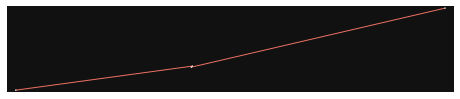

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a16dd30>)

In [3]:
new_service = Service(id='new_service', routes=[route])
new_service.plot()

In [4]:
n.schedule.add_service(Service(id='new_service', routes=[route]))

2021-04-13 17:25:31,869 - Added Service with index `new_service`, data={'id': 'new_service', 'name': 'N55'} and Routes: ['new_route']


<Service instance at 4463846512: with 1 routes>

In [5]:
n.schedule.add_route('20274', route)

2021-04-13 17:25:31,927 - Route with ID `new_route` within already exists in the Schedule. This Route will be reindexed to `20274_4`
2021-04-13 17:25:31,960 - Reindexed Route from new_route to 20274_4
2021-04-13 17:25:31,975 - Added Route with index `20274_4`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': '20274_4', 'route': [], 'await_departure': [True, True, True, True], 'ordered_stops': ['490000235X', 'new_stop', 'other_new_stop', '490010689KB']} to Service `20274` within the Schedule


<Route instance at 4729484064: with 4 stops and 2 trips>

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/osmnx/utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


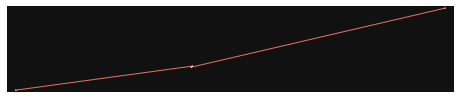

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119dcb748>)

In [6]:
n.schedule['new_service'].plot()

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/osmnx/utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


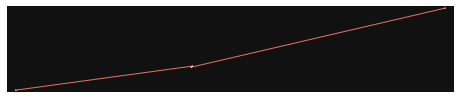

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119d65a90>)

In [7]:
n.schedule.route('20274_4').plot()

You can also refer to existing stops in the `Schedule` when creating a`Route` to be added. You can either just pass Stop IDs as strings or use a stop method on the schedule to take and use that stop object. Note that in the case of the former (passing ID strings), the route will not have the spatial information for those stops until it is added to the Schedule.

In [8]:
r = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['some_trip_1'], 
           'trip_departure_time': ['16:23:00'], 
           'vehicle_id': ['some_bus_2']},
   arrival_offsets=['00:00:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:06:00'],
   id='another_new_route',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True],
   stops=['490000235X.link:834', 
          '490010689KB.link:981']
)

In [9]:
r.graph().nodes['490000235X.link:834']

{'routes': {'another_new_route'}}

In [10]:
n.schedule.add_route('20274', r)

2021-04-13 17:25:33,040 - Added Route with index `another_new_route`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id': ['some_bus_2']}, 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route', 'route': [], 'await_departure': [True, True], 'ordered_stops': ['490000235X.link:834', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 4727682944: with 2 stops and 1 trips>

In [11]:
r.graph().nodes['490000235X.link:834']

{'services': {'14134', '18853', '20274'},
 'routes': {'VJ12ba6089dfb2733e29c415a1a0015fef30fd5305',
  'VJ256e98df611ff48afe737ddc81cbcde82e4e81c8',
  'VJ2aba67e3ed98f2ed5f5966c1ac394cbf6d1943d7',
  'VJ375a660d47a2aa570aa20a8568012da8497ffecf',
  'VJ4e2b897edf0e7b8a8e3b5516ab43ce56f72c5cff',
  'VJa7f37392e276aeac26c7e73bbc05e6a71af38dba',
  'VJd78967364a302cf232c5139d40622dcb6c238c9e',
  'VJdf3936da1a51eb33db594ef99738802c14b19995',
  'VJf3e316e5e605bb512147dee2a989be5a82ef1b5f',
  'VJf9a22035ae6f25bb420df833474943ad76065c89',
  'another_new_route'},
 'id': '490000235X.link:834',
 'x': 529981.7958802709,
 'y': 181412.0975758662,
 'epsg': 'epsg:27700',
 'name': 'Tottenham Court Road Station (Stop X)',
 'lon': 51.51668503324075,
 'lat': -0.12809598708996447,
 's2_id': 2507584377443783851,
 'additional_attributes': {'isBlocking', 'linkRefId', 'name'},
 'linkRefId': '834',
 'isBlocking': 'false'}

In [12]:
r = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['some_trip_1'], 
           'trip_departure_time': ['16:23:00'], 
           'vehicle_id': ['some_bus_2']},
   arrival_offsets=['00:00:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:06:00'],
   id='another_new_route_2',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True],
   stops=[n.schedule.stop('490000235X.link:834'), 
          n.schedule.stop('490010689KB.link:981')]
)
n.schedule.add_route('20274', r)

2021-04-13 17:25:33,078 - Added Route with index `another_new_route_2`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id': ['some_bus_2']}, 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_2', 'route': [], 'await_departure': [True, True], 'ordered_stops': ['490000235X.link:834', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 4727634856: with 2 stops and 1 trips>

Note that for a Schedule to be a valid MATSim network, each stop referred to by a route needs a `linkRefId` attribute which links the stop to the `Network`.

Trying to add Stops with IDs already in the Schedule will result in an error, unless the `force=True` is set. The added route/service will inherit the data stored under those stops. The idea is that you can either specify the Stops in the route/service to be added correctly, or if they are to be changed, you use a dedicated method - check section 'Modifying data' below.

In [13]:
route = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['fun_trip_1', 'fun_trip_2'], 
           'trip_departure_time': ['03:53:00', '16:23:00'], 
           'vehicle_id': ['fun_bus_1', 'fun_bus_2']},
   arrival_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   id='another_new_route_3',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True, True, True],
   stops=[
       Stop(id='490000235X.link:834', x=529981, y=181412, epsg='epsg:27700'),
       Stop(id='new_stop', x=529500, y=181300, epsg='epsg:27700', name='New Stop'),
       Stop(id='other_new_stop', x=529502, y=181302, epsg='epsg:27700', name='Other New Stop'),
       Stop(id='490010689KB.link:981', x=529166, y=181256, epsg='epsg:27700')
   ]
)

n.schedule.add_route('20274', route, force=True)

2021-04-13 17:25:34,867 - The following stops will inherit the data currently stored under those Stop IDs in the Schedule: ['490000235X.link:834', '490010689KB.link:981'].
2021-04-13 17:25:34,875 - Added Route with index `another_new_route_3`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_3', 'route': [], 'await_departure': [True, True, True, True], 'ordered_stops': ['490000235X.link:834', 'new_stop', 'other_new_stop', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 4727609328: with 4 stops and 2 trips>

Note the message above: `The following stops will inherit the data currently stored under those Stop IDs in the Schedule: ['490000235X.link:834', '490010689KB.link:981'].`

NOTE: adding routes and services results in new vehicles (unless you reuse the ones already in the Schedule---beware that the same vehicle cannot service multiple trips at the same time, genet does not currently have checks for this, the user needs to be mindful of the physics of shared vehicles). New vehicles need definitions, you can add them yourself to `schedule.vehicles['vehicle_id'] = {'type': 'bus'}` ensuring this vehicle type is defined in `schedule.vehicle_types['bus']`, or you can use a genet method to generate those vehicles, the type will be derived from the mode of the route. Then you can check if all of the types that vehicles are referring to have definitions.

In [14]:
len(n.schedule.vehicles)

13290

In [15]:
n.schedule.generate_vehicles()

/Users/kasia.kozlowska/PycharmProjects/ABM/genet/genet/schedule_elements.py:1232: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  self.vehicles = {**df.T.to_dict(), **self.vehicles}


In [16]:
n.schedule.validate_vehicle_definitions()

True

In [17]:
len(n.schedule.vehicles)

13293

In [18]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
0,2021-04-13 17:25:31,add,service,None,new_service,None,"{'id': 'new_service', 'name': 'N55'}","[(add, , [('id', 'new_service'), ('name', 'N55..."
1,2021-04-13 17:25:31,add,route,None,20274_4,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."
2,2021-04-13 17:25:33,add,route,None,another_new_route,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."
3,2021-04-13 17:25:33,add,route,None,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."
4,2021-04-13 17:25:34,add,route,None,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."


There are no methods to add `Stop` objects on their own. They are added to the Schedule with `Route` and `Service` objects.

### Routing added Services/Routes

You can use a method in GeNet to relate the Stops of PT services and find network routes between them. First you need to know the ID of the Service you want to snap (you can also snap the entire schedule, but depending on the size and complexity of your network and schedule it might take a long time). GeNet will then relate all stops in that service to a link in the Network graph and route all of the `Route`s of the `Service` object. It will do this for directed subsets (subgraphs) of the Service (e.g. if you have a Northbound and Southboud service, the stops may have to find different links in the graph)

There are a lot of different parameters you can add to this method, that give you a bit more control. 
- For example you can vary the threshold for snapping stops to links. There are two parameters, the overall threshold and a step size; when snapping, the search area for links increases in steps until some links are found, we don't use the threshold right away because we don't want to have too many choices for snapping (makes it a little less heavy computationally)).
- You can specify additional modes (when snapping, genet will consider a modal subset of the network that matches the pt service, e.g. bus, but you might want to use links that allow cars too).
- You can opt for splitting the problem of snapping by direction. GeNet will then solve a series of problems for subgraphs (disjoint w.r.t. edges) of the Service. This is useful for rail type services that might share the same stop regardless of direction (in comparison to buses which have distinct bus stops, depending on which way they're travelling).

Check the method's doc string for up to date details.

In [19]:
n.schedule['new_service'].route('new_route').route

[]

In [20]:
n.schedule['new_service'].route('new_route').graph().nodes()

NodeView(('490010689KB', '490000235X', 'new_stop', 'other_new_stop'))

In [21]:
n.route_service('new_service')

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-04-13 17:25:38,332 - Building Maximum Stable Set for PT graph with 4 stops and 3 edges
2021-04-13 17:25:41,100 - This Maximum Stable Set Problem is partially viable.
2021-04-13 17:25:41,101 - Maximum Stable Set problem to snap the PT graph to the network is partially viable, meaning not all stops have found a link to snap to within the distance_threshold.Partial snapping is ON, this problem will proceed to the solver.
2021-04-13 17:25:41,102 - Passing problem to solver
2021-04-13 17:25:41,105 - Initializing ordered Set vertices with a fundamentally unordered data source (type: set).

In [22]:
n.schedule['new_service'].route('new_route').route

['artificial_link===from:490000235X===to:490000235X',
 'artificial_link===from:490000235X===to:9521035',
 '3154',
 '979',
 '980',
 '981']

In [23]:
n.schedule['new_service'].route('new_route').graph().nodes()

NodeView(('490010689KB.link:981', 'new_stop.link:3154', '490000235X.link:artificial_link===from:490000235X===to:490000235X', 'other_new_stop.link:3154'))

## Reindexing

In [24]:
n.schedule['new_service'].reindex(new_id='more_appropriate_id')

2021-04-13 17:25:42,617 - Reindexed Service from new_service to more_appropriate_id


In [25]:
n.schedule.route('new_route').reindex(new_id='more_appropriate_route_id')

2021-04-13 17:25:42,633 - Reindexed Route from new_route to more_appropriate_route_id


In [26]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
3,2021-04-13 17:25:33,add,route,None,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."
4,2021-04-13 17:25:34,add,route,None,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, , [('route_short_name', 'N55'), ('mode'..."
5,2021-04-13 17:25:41,modify,route,new_route,new_route,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","{'route_short_name': 'N55', 'mode': 'bus', 'tr...","[(add, route, [(0, 'artificial_link===from:490..."
6,2021-04-13 17:25:42,modify,service,new_service,more_appropriate_id,{'id': 'new_service'},{'id': 'more_appropriate_id'},"[(change, id, (new_service, more_appropriate_i..."
7,2021-04-13 17:25:42,modify,route,new_route,more_appropriate_route_id,{'id': 'new_route'},{'id': 'more_appropriate_route_id'},"[(change, id, (new_route, more_appropriate_rou..."


## Removing Stops, Routes, Services

In [27]:
n.schedule.remove_service('more_appropriate_id')

2021-04-13 17:25:42,698 - Removed Service with index `more_appropriate_id`, data={'id': 'more_appropriate_id', 'name': 'N55'} and Routes: {'more_appropriate_route_id'}


In [28]:
for route_id in {'another_new_route', 'another_new_route_2', 'another_new_route_3'}:
    n.schedule.remove_route(route_id)

2021-04-13 17:25:42,771 - Removed Route with index `another_new_route`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id': ['some_bus_2']}, 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route', 'route': [], 'await_departure': [True, True], 'ordered_stops': ['490000235X.link:834', '490010689KB.link:981']}. It was linked to Service `20274`.
2021-04-13 17:25:42,804 - Removed Route with index `another_new_route_3`, data={'route_short_name': 'N55', 'mode': 'bus', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_3', 'route': [], 'await_departur

In [29]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
7,2021-04-13 17:25:42,modify,route,new_route,more_appropriate_route_id,{'id': 'new_route'},{'id': 'more_appropriate_route_id'},"[(change, id, (new_route, more_appropriate_rou..."
8,2021-04-13 17:25:42,remove,service,more_appropriate_id,None,"{'id': 'more_appropriate_id', 'name': 'N55'}",None,"[(remove, , [('id', 'more_appropriate_id'), ('..."
9,2021-04-13 17:25:42,remove,route,another_new_route,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."
10,2021-04-13 17:25:42,remove,route,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."
11,2021-04-13 17:25:42,remove,route,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."


You can also remove `Stop`s. This will disconnect `Route`s and `Service`s using that `Stop`s and likely render them invalid. The method will warn you which `Route`s and `Servce`s are affected.

In [30]:
n.schedule.remove_stop('new_stop')

2021-04-13 17:25:42,879 - Removed Stop with index `new_stop`, data={'id': 'new_stop', 'x': 529500.0, 'y': 181300.0, 'epsg': 'epsg:27700', 'name': 'New Stop', 'lon': -0.1350768098744082, 'lat': 51.51578819710296, 's2_id': 5221390696585158415, 'additional_attributes': set()}. Routes affected: {'20274_4'}. Services affected: {'20274'}.


You can also remove `Stop`s. This will disconnect `Route`s and `Service`s using that `Stop`s and likely render them invalid. The method will warn you which `Route`s and `Servce`s are affected.

In [31]:
n.schedule.remove_unsused_stops()

2021-04-13 17:25:42,946 - Removed Stop with index `490000173RF`, data={'id': '490000173RF', 'x': 529005.768975204, 'y': 181304.1022004814, 'name': 'Oxford Circus Stn Margaret St (Stop RF)', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:42,964 - Removed Stop with index `490000091F`, data={'id': '490000091F', 'x': 528839.7441194298, 'y': 182137.34852809936, 'name': 'Great Portland Street (Stop F)', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:42,991 - Removed Stop with index `9400ZZLUWRR3`, data={'id': '9400ZZLUWRR3', 'x': 529227.7798224052, 'y': 182216.41780797765, 'name': 'Warren Street Underground Station', 'stopAreaId': '940GZZLUWRR', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:43,004 - Removed Stop with index `9400ZZLUOXC6`, data={'id': '9400ZZLUOXC6', 'x': 529013.7410255029, 'y': 1

2021-04-13 17:25:43,474 - Removed Stop with index `9400ZZLUTCR4`, data={'id': '9400ZZLUTCR4', 'x': 529825.787229313, 'y': 181325.43110254267, 'name': 'Tottenham Court Road Underground Station', 'stopAreaId': '940GZZLUTCR', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:43,481 - Removed Stop with index `9400ZZLUGPS2`, data={'id': '9400ZZLUGPS2', 'x': 528862.3135234541, 'y': 182194.44889770175, 'name': 'Great Portland Street Underground Station', 'stopAreaId': '940GZZLUGPS', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:43,489 - Removed Stop with index `490000091E`, data={'id': '490000091E', 'x': 528867.770390693, 'y': 182083.31184164743, 'name': 'Great Portland Street (Stop E)', 'isBlocking': 'false', 'epsg': 'epsg:27700'}. Routes affected: set(). Services affected: set().
2021-04-13 17:25:43,496 - Removed Stop with index `490000356NE`, data={'id': '490000

## Modifying data stored for Stops, Routes, Services

### Applying known or pre-computed changes
Applying changes or new attributes to Services, Routes and Stops can be done via Schedule level methods. They all work with a dictionary where the keys are the object IDs and the values are dictionaries holding attribute names and values. The method to extract a DataFrame on attributes comes in handy here. E.g.

In [32]:
df = n.schedule.service_attribute_data(keys='name')
df.head()

,name
17732,N20
12430,205
15234,134
14134,98
18915,N5


DataFrames are easy to work with. Youcould for exmaple manipulate the names or use other data to change these. For demonstration here, let's just set the names to something easy.

In [33]:
df['name'] = df['name'].apply(lambda x: f'Service_{x}')
df.head()

,name
17732,Service_N20
12430,Service_205
15234,Service_134
14134,Service_98
18915,Service_N5


You can then convert this to a dictionary and pass it to the `apply_attributes_to_services` method.

In [34]:
n.schedule.apply_attributes_to_services(df.T.to_dict())

2021-04-13 17:25:43,663 - Changed Service attributes for 9 services


In [35]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
52,2021-04-13 17:25:43,modify,service,18915,18915,"{'id': '18915', 'name': 'N5'}","{'id': '18915', 'name': 'Service_N5'}","[(change, name, (N5, Service_N5))]"
53,2021-04-13 17:25:43,modify,service,18853,18853,"{'id': '18853', 'name': 'N8'}","{'id': '18853', 'name': 'Service_N8'}","[(change, name, (N8, Service_N8))]"
54,2021-04-13 17:25:43,modify,service,14073,14073,"{'id': '14073', 'name': '94'}","{'id': '14073', 'name': 'Service_94'}","[(change, name, (94, Service_94))]"
55,2021-04-13 17:25:43,modify,service,15660,15660,"{'id': '15660', 'name': '113'}","{'id': '15660', 'name': 'Service_113'}","[(change, name, (113, Service_113))]"
56,2021-04-13 17:25:43,modify,service,20274,20274,"{'id': '20274', 'name': 'N55'}","{'id': '20274', 'name': 'Service_N55'}","[(change, name, (N55, Service_N55))]"


You can do the same for `Routes` and `Stops`. Your dictionaries cannot however hold changes to indices. You will encounter an error and should use `reindex` methods for such operations.

In [36]:
n.schedule.apply_attributes_to_routes(
    {'VJ375a660d47a2aa570aa20a8568012da8497ffecf': {
        'name': 'my_favourite_route', 
        'mode': 'piggyback'
    }}
)

2021-04-13 17:25:43,720 - Changed Route attributes for 1 routes


In [37]:
n.schedule.apply_attributes_to_stops(
    {'490000235YB.link:574': {'new_attribute': 'hello!'}}
)

2021-04-13 17:25:43,737 - Changed Stop attributes for 1 stops


In [38]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
54,2021-04-13 17:25:43,modify,service,14073,14073,"{'id': '14073', 'name': '94'}","{'id': '14073', 'name': 'Service_94'}","[(change, name, (94, Service_94))]"
55,2021-04-13 17:25:43,modify,service,15660,15660,"{'id': '15660', 'name': '113'}","{'id': '15660', 'name': 'Service_113'}","[(change, name, (113, Service_113))]"
56,2021-04-13 17:25:43,modify,service,20274,20274,"{'id': '20274', 'name': 'N55'}","{'id': '20274', 'name': 'Service_N55'}","[(change, name, (N55, Service_N55))]"
57,2021-04-13 17:25:43,modify,route,VJ375a660d47a2aa570aa20a8568012da8497ffecf,VJ375a660d47a2aa570aa20a8568012da8497ffecf,"{'route_short_name': 'N55', 'mode': 'bus', 'tr...","{'route_short_name': 'N55', 'mode': 'piggyback...","[(change, mode, (bus, piggyback)), (add, , [('..."
58,2021-04-13 17:25:43,modify,stop,490000235YB.link:574,490000235YB.link:574,"{'services': {'14134', '18853', '20274'}, 'rou...","{'services': {'14134', '18853', '20274'}, 'rou...","[(add, , [('new_attribute', 'hello!')])]"


You can use `route_trips_to_dataframe` to extract all of the trips, their departures and vehicle IDs associated with the trips in the schedule. Trip ids need not be unique, route IDs provide a secondary index. Associated service IDs are also given for convenience.

In [39]:
trips = n.schedule.route_trips_to_dataframe(gtfs_day='20210101')

In [40]:
trips.head()

,service_id,route_id,trip_id,trip_departure_time,vehicle_id
0,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,VJ004714becf735c172cf17a0329190c27b61451ae_19:...,2021-01-01 19:18:00,veh_1778_bus
1,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,VJ11748f78bfd412185d8deaf4ad61cd4f1477d6b1_14:...,2021-01-01 14:56:00,veh_1779_bus
2,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,VJ28bbf4f0d3469f24be40acbdf6e8720679638358_14:...,2021-01-01 14:24:00,veh_1780_bus
3,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,VJ2a974ddfa37ddc24e089d82ab79df699b8c44630_19:...,2021-01-01 19:30:00,veh_1781_bus
4,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,VJ35d0be40bd5b63e1d5a9d08ff4b9081fd8fd87c6_14:...,2021-01-01 14:08:00,veh_1782_bus


Let's change all of the trip ids to something shorter

In [41]:
trips['trip_id'] = 'trip_' + trips.index.to_series().astype(str)
trips.head()

,service_id,route_id,trip_id,trip_departure_time,vehicle_id
0,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,trip_0,2021-01-01 19:18:00,veh_1778_bus
1,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,trip_1,2021-01-01 14:56:00,veh_1779_bus
2,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,trip_2,2021-01-01 14:24:00,veh_1780_bus
3,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,trip_3,2021-01-01 19:30:00,veh_1781_bus
4,15234,VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,trip_4,2021-01-01 14:08:00,veh_1782_bus


You can `set_route_trips_dataframe` which takes this dataframe and applies changes to all route trips based on the data in the dataframe. This means you can generate this DataFrame as shown below, manipulate trips (delete them, add new ones), change their departure times or change their vehicle ids to be shared for differnt trips, perhaps on some temporal logic and as long as the dataframe has the same schema, you can use it to set new trips in the schedule. This will appear in the changelog as a route level modify event.

Nb removing all trips of the same route from the dataframe will have no effect when being applied. If there is data in the dataframe for a route, all of its trips will be replaced by the data in the dataframe, and if there is no data for a route in the frame, no changes will be applied to that route (i.e. the trips attribute for routes missing from the dataframe will not be set as empty).

In [42]:
n.schedule.set_route_trips_dataframe(trips)
n.schedule.route_attribute_data(keys=[{'trips': 'trip_id'}])

2021-04-13 17:25:44,464 - Changed Route attributes for 69 routes


,trips::trip_id
VJd4cbfb092a104ac6a3164a86e9765f68734fdfcf,"[trip_0, trip_1, trip_2, trip_3, trip_4, trip_..."
VJ8f9aea7491080b0137d3092706f53dc11f7dba45,"[trip_15, trip_16, trip_17, trip_18, trip_19, ..."
VJ1a8cc306354fdc322d739ae644eb73444341d08d,"[trip_21, trip_22, trip_23, trip_24, trip_25, ..."
VJ1cf651142378958b52229bfe1fa552e49136e60e,"[trip_37, trip_38, trip_39, trip_40, trip_41, ..."
VJ323d02e117552af1565f2ff1273a612655c829c4,[trip_83]
...,...
VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13,"[trip_1386, trip_1387]"
VJ9b58a59e3d74941586a5bca7726a8aa624da67fc,"[trip_1388, trip_1389, trip_1390, trip_1391, t..."
VJf9a22035ae6f25bb420df833474943ad76065c89,"[trip_1547, trip_1548, trip_1549]"
VJ06cd41dcd58d947097df4a8f33234ef423210154,"[trip_1550, trip_1551, trip_1552, trip_1553, t..."


### Applying changes using functions or dictionary mappings

If you have some logic that can be written into a function of object's attributes, you can pass this to `apply_function_to_x` methods. You need to select `location`, which refers to the name of the attribute the result should be stored under. It can already exist and be overwritten. The function passed, is not expected to work with all objects. It will fail silently, only evaluating and generating outputs where possible.

In [43]:
from shapely.geometry import Point

def add_shapely_geometry_points(stop_attribs):
    return Point(stop_attribs['x'], stop_attribs['y'])

n.schedule.apply_function_to_stops(add_shapely_geometry_points, location='geometry')

2021-04-13 17:25:44,593 - Changed Stop attributes for 87 stops


In [44]:
n.schedule.change_log().tail(2)

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
213,2021-04-13 17:25:44,modify,stop,other_new_stop.link:3154,other_new_stop.link:3154,"{'services': set(), 'routes': set(), 'id': 'ot...","{'services': set(), 'routes': set(), 'id': 'ot...","[(add, , [('geometry', <shapely.geometry.point..."
214,2021-04-13 17:25:44,modify,stop,490000235X.link:artificial_link===from:4900002...,490000235X.link:artificial_link===from:4900002...,{'id': '490000235X.link:artificial_link===from...,{'id': '490000235X.link:artificial_link===from...,"[(add, , [('geometry', <shapely.geometry.point..."


In [45]:
n.schedule.stop_attribute_data(keys=['name', 'x', 'y', 'geometry']).head()

,name,x,y,geometry
490000235X.link:834,Tottenham Court Road Station (Stop X),529981.795880,181412.097576,POINT (529981.7958802709 181412.0975758662)
490000235YB.link:574,Oxford Street Soho Street (Stop YB),529570.781323,181336.281593,POINT (529570.7813227688 181336.2815925331)
490014214HE.link:3154,Wardour Street (Stop OM),529477.750156,181314.437043,POINT (529477.7501560802 181314.4370430721)
490010689KB.link:981,Great Titchfield Street Oxford Circus Station...,529166.734973,181256.336723,POINT (529166.7349732723 181256.3367228433)
490010689OJ.link:1787,Great Titchfield Street Oxford Circus Station...,529227.773057,181280.477507,POINT (529227.7730568129 181280.4775071898)


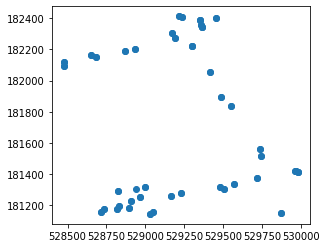

In [46]:
from geopandas import GeoDataFrame
GeoDataFrame(n.schedule.stop_attribute_data(keys='geometry')).plot()

In [47]:
n.schedule.stop('490000235YB.link:574').__dict__

{'id': '490000235YB.link:574',
 'x': 529570.7813227688,
 'y': 181336.2815925331,
 'epsg': 'epsg:27700',
 'name': 'Oxford Street  Soho Street (Stop YB)',
 'lat': -0.13404398709291862,
 'lon': 51.51609803324078,
 's2_id': 2507584474601580133,
 'additional_attributes': {'geometry',
  'isBlocking',
  'linkRefId',
  'new_attribute'},
 'linkRefId': '574',
 'isBlocking': 'false',
 'new_attribute': 'hello!',
 'geometry': <shapely.geometry.point.Point at 0x119c48780>}

For this let's say we want to reduce the number of trips. For simplicity of demonstration we don't have about which trips we delete, but logic around timings of trips can be added in this function, as the trips are saved as one of routes attributes (check out the summary methods)

In [48]:
# before
len(n.schedule.route_trips_to_dataframe())

1564

In [49]:
def reduce_trips(attribs):
    # just delete any other trip
    attribs['trips']['trip_id'] = attribs['trips']['trip_id'][::2]
    attribs['trips']['trip_departure_time'] = attribs['trips']['trip_departure_time'][::2]
    attribs['trips']['vehicle_id'] = attribs['trips']['vehicle_id'][::2]
    return attribs['trips']

n.schedule.apply_function_to_routes(reduce_trips, 'trips')

2021-04-13 17:25:45,928 - Changed Route attributes for 69 routes


In [50]:
# after
len(n.schedule.route_trips_to_dataframe())

793

Note, this could also be done using the `route_trips_to_dataframe` and `set_route_trips_dataframe` mentioned above.

Let's give an example of using a mapping. We can re-use the service name DataFrame we generated above.

In [51]:
df['new_name'] = 'Brand_new_name' + df['name']
df.head()

,name,new_name
17732,Service_N20,Brand_new_nameService_N20
12430,Service_205,Brand_new_nameService_205
15234,Service_134,Brand_new_nameService_134
14134,Service_98,Brand_new_nameService_98
18915,Service_N5,Brand_new_nameService_N5


In [52]:
name_map = dict(zip(df['name'], df['new_name']))
name_map

{'Service_N20': 'Brand_new_nameService_N20',
 'Service_205': 'Brand_new_nameService_205',
 'Service_134': 'Brand_new_nameService_134',
 'Service_98': 'Brand_new_nameService_98',
 'Service_N5': 'Brand_new_nameService_N5',
 'Service_N8': 'Brand_new_nameService_N8',
 'Service_94': 'Brand_new_nameService_94',
 'Service_113': 'Brand_new_nameService_113',
 'Service_N55': 'Brand_new_nameService_N55'}

In this case, `location` refers to the attribute to be mapped.

In [53]:
n.schedule.apply_function_to_services(name_map, location='name')

2021-04-13 17:25:46,209 - Changed Service attributes for 9 services


In [54]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
288,2021-04-13 17:25:46,modify,service,18915,18915,"{'id': '18915', 'name': 'Service_N5'}","{'id': '18915', 'name': 'Brand_new_nameService...","[(change, name, (Service_N5, Brand_new_nameSer..."
289,2021-04-13 17:25:46,modify,service,18853,18853,"{'id': '18853', 'name': 'Service_N8'}","{'id': '18853', 'name': 'Brand_new_nameService...","[(change, name, (Service_N8, Brand_new_nameSer..."
290,2021-04-13 17:25:46,modify,service,14073,14073,"{'id': '14073', 'name': 'Service_94'}","{'id': '14073', 'name': 'Brand_new_nameService...","[(change, name, (Service_94, Brand_new_nameSer..."
291,2021-04-13 17:25:46,modify,service,15660,15660,"{'id': '15660', 'name': 'Service_113'}","{'id': '15660', 'name': 'Brand_new_nameService...","[(change, name, (Service_113, Brand_new_nameSe..."
292,2021-04-13 17:25:46,modify,service,20274,20274,"{'id': '20274', 'name': 'Service_N55'}","{'id': '20274', 'name': 'Brand_new_nameService...","[(change, name, (Service_N55, Brand_new_nameSe..."
